In [1]:
import os
import glob
import requests
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from string import ascii_uppercase


from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook, output_file
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.models import LassoSelectTool, HoverTool, TapTool, LabelSet
from bokeh.models import LinearColorMapper, ColorBar, LogColorMapper
from bokeh.models import WMTSTileSource
from bokeh.tile_providers import CARTODBPOSITRON, CARTODBPOSITRON_RETINA, STAMEN_TERRAIN
from bokeh.palettes import Viridis256, Magma256, Inferno256

from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE) 

output_notebook()


%matplotlib inline
%config IPCompleter.use_jedi = False

Loading BokehJS ...

Loading BokehJS ...

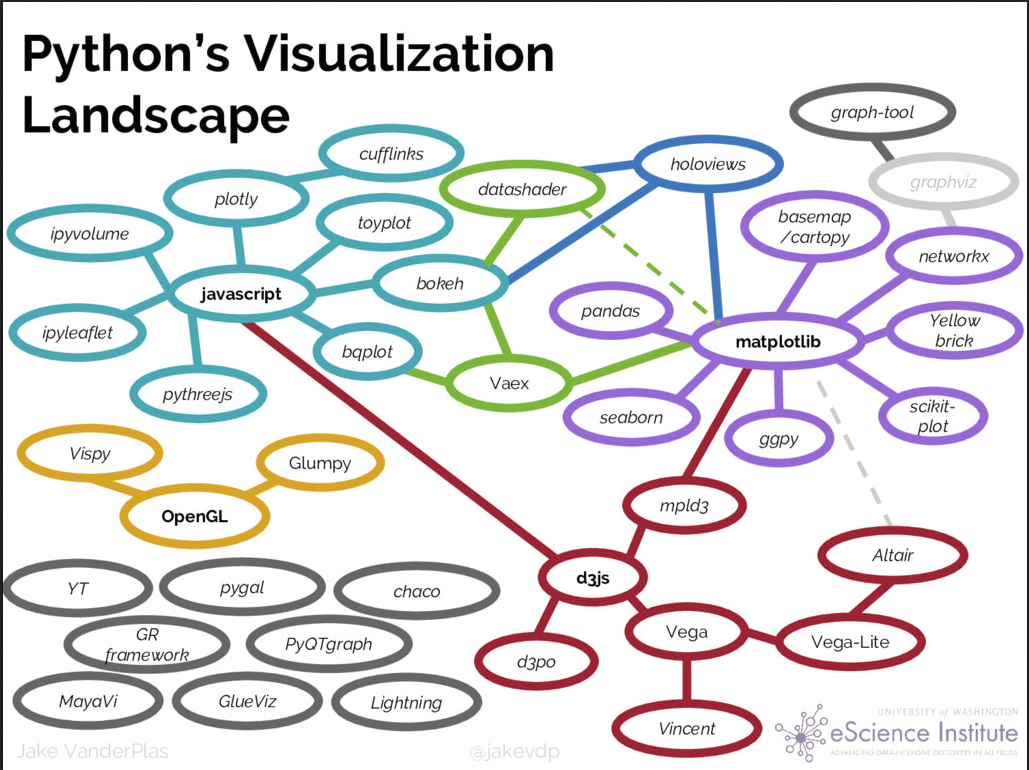

In [2]:
from IPython.display import Image
Image('jakevdp_landscape.png')

In [ ]:
## hacer el mapa de estaciones poco a poco
# ver como hacer el streaming o poner un slider

## Bokeh básico

In [3]:
# tools="pan,wheel_zoom,box_zoom,reset"

p = figure(plot_width=400, plot_height=400)

x = [1, 2, 3, 4, 5]
y = [2, 5, 8, 2, 7]

r = p.circle(x, y, size=20, fill_alpha=0.5)

show(p)

In [5]:
p = figure(plot_width=400, plot_height=400)

data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 5, 8, 2, 7]}

source = ColumnDataSource(data)

r = p.circle('x', 'y', size=20,
             source=source,
             selection_color="firebrick",
             nonselection_fill_alpha=0.2,
             nonselection_fill_color="grey",
             nonselection_line_color="firebrick",
             nonselection_line_alpha=1.0)

p.add_tools(LassoSelectTool())
p.add_tools(TapTool())

# hover 

tooltips = [
    ('x', '@x'),
    ('y', '@y')
]

p.add_tools(HoverTool(tooltips=tooltips, mode='mouse'))

show(p)

In [6]:
p = figure(plot_width=600, plot_height=500)

data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 5, 8, 2, 7],
        'nombre': [l for l in ascii_uppercase[0:5]]}

source = ColumnDataSource(data)

r = p.circle('x', 'y', size=20, source=source)

tooltips = [
    ('x', '@x'),
    ('y', '@y'),
    ('ID', '@nombre')
]

p.add_tools(HoverTool(tooltips=tooltips, mode='mouse'))
p.xaxis.axis_label = 'x (m)'
p.yaxis.axis_label = 'y (m)'

labels = LabelSet(x='x', y='y', text='nombre',
                  x_offset=-5, y_offset=10, source=source)

p.add_layout(labels)

show(p)

In [7]:
p = figure(plot_width=600, plot_height=500, x_range=(0, 10), y_range=(0, 15))

data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 5, 8, 2, 7],
        'z': [20, 12, 50, 42, 29],
        'nombre': [l for l in ascii_uppercase[0:5]]}

source = ColumnDataSource(data)

# colorbar
color_mapper = LinearColorMapper(palette=Viridis256,
                                 low=min(source.data['z']),
                                 high=max(source.data['z']))

r = p.circle('x', 'y', size=20, source=source,
             color={'field': 'z', 'transform': color_mapper})

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=5, location=(0, 0), title='z')
p.add_layout(color_bar, 'left')

# hover
tooltips = [
    ('x', '@x'),
    ('y', '@y'),
    ('ID', '@nombre')
]

p.add_tools(HoverTool(tooltips=tooltips, mode='mouse'))
p.xaxis.axis_label = 'x (m)'
p.yaxis.axis_label = 'y (m)'

# label set
labels = LabelSet(x='x', y='y', text='nombre',
                  x_offset=-5, y_offset=10, source=source)
p.add_layout(labels)

show(p)

In [8]:
df = pd.DataFrame(data)
df

,nombre,x,y,z
0,A,1,2,20
1,B,2,5,12
2,C,3,8,50
3,D,4,2,42
4,E,5,7,29


In [ ]:
## Ejercicio. Gráfica de las estaciones coloreadas por número de Arribos

In [9]:
df_estaciones = pd.read_csv('data/estaciones_ecobici.csv')
df_estaciones.head()

,estacion_id,latitud,longitud
0,448,19.426611,-99.144470
1,443,19.359655,-99.162025
2,416,19.371308,-99.177607
3,437,19.364808,-99.176022
4,438,19.364797,-99.174583


In [10]:
df_viajes = pd.read_parquet('data/viajes_ecobici.parquet', engine='pyarrow')
df_arribos = df_viajes.groupby('Ciclo_Estacion_Arribo', as_index=False).Bici.count()
df_arribos = df_arribos.rename(columns={'Ciclo_Estacion_Arribo': 'estacion_id',
                                        'Bici': 'num_arribos'})
df_arribos.head()

,estacion_id,num_arribos
0,1,26396
1,2,10562
2,3,14087
3,4,11457
4,5,9802


In [14]:
def crear_mapa(df):
    df = df.copy()
    # asignar proyeccion de mercator
    y, x = wgs84_to_web_mercator(df.latitud.values, df.longitud.values)
    df = df.assign(x=x, y=y)

    # mapa
    lon_range = (-99.25, -99.1)
    lat_range = (19.34, 19.46)
    y_range, x_range = wgs84_to_web_mercator(
        np.array(lat_range), np.array(lon_range))
    x_range = (x_range[0], x_range[1])
    y_range = (y_range[0], y_range[1])

    p = figure(output_backend='webgl', title='Mapa ecobici',
               plot_width=900, plot_height=700,
               x_range=x_range, y_range=y_range,
               toolbar_location='right')
    p.axis.visible = False
    osm_tiles = WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')
    p.add_tile(osm_tiles)

    # dibujar estaciones
    df = df.assign(size_circles=np.log(df_mapa.num_arribos - 400) * 1.5)
    source = ColumnDataSource(df)
    color_mapper = LinearColorMapper(palette=Viridis256,
                                     low=min(source.data['num_arribos']),
                                     high=max(source.data['num_arribos']))
    r = p.circle('x', 'y', size='size_circles',
                 source=source, alpha=0.9,
                 color={'field': 'num_arribos', 'transform': color_mapper})
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12,
                         location=(0, 0), title='Arribos')
    p.add_layout(color_bar, 'left')
    # hover
    tooltips = [
        ('latitud', '@latitud'),
        ('longitud', '@longitud'),
        ('Estacion', '@estacion_id'),
        ('Arribos', '@num_arribos')
    ]
    p.add_tools(HoverTool(tooltips=tooltips, mode='mouse'))
    return p

show(crear_mapa(df_arribos))

AttributeError: 'DataFrame' object has no attribute 'latitud'

## Agregar tiles

In [12]:
df_estaciones = pd.read_csv('data/estaciones_ecobici.csv')

df_viajes = pd.read_parquet('data/viajes_ecobici.parquet', engine='pyarrow')
df_arribos = df_viajes.groupby('Ciclo_Estacion_Arribo', as_index=False).Bici.count()
df_arribos = df_arribos.rename(columns={'Ciclo_Estacion_Arribo': 'estacion_id',
                                        'Bici': 'num_arribos'})


df_mapa = pd.merge(df_estaciones, df_arribos, on='estacion_id', how='inner')
df_mapa.head()

,estacion_id,latitud,longitud,num_arribos
0,448,19.426611,-99.144470,4507
1,443,19.359655,-99.162025,2042
2,416,19.371308,-99.177607,1760
3,437,19.364808,-99.176022,2024
4,438,19.364797,-99.174583,1887


In [13]:
def wgs84_to_web_mercator(latitudes,
                          longitudes,
                          in_proj: str = 'epsg:4326',
                          out_proj: str = 'epsg:3857'):
    """Utility function to transform latitude and longitude values 
    to web marcator values"""
    output =  pyproj.transform(pyproj.Proj(init=in_proj),
                               pyproj.Proj(init=out_proj),
                               longitudes, latitudes)
    return output[::-1]

lat, lon = 19.420487, -99.173006
y, x = wgs84_to_web_mercator(lat, lon)

In [16]:
show(crear_mapa(df_mapa))

## Interacciones (ipywidgets)

In [ ]:
import ipywidgets
from ipywidgets import interact

In [ ]:
slider = ipywidgets.IntSlider()
slider

In [ ]:
slider.value = 90

In [ ]:
texto = ipywidgets.IntText()
texto

In [ ]:
mylink = ipywidgets.jslink((slider, 'value'), (texto, 'value'))

In [ ]:
valor = 0

In [ ]:
def funcion(x):
    return x // 2

interact(funcion, x=(0, 10));

In [ ]:
def funcion(x):
    return x

interact(funcion, x=False);

In [ ]:
def saludar(x):
    if x == 'ES':
        return 'Hola'
    elif x == 'EN':
        return 'Hello'
    else:
        return b'\xF0\x9F\x98\x90'.decode('utf-8')


interact(saludar, x=['ES', 'EN', 'FR']);

In [ ]:
# x={'ES': 'Hola', 'EN': 'Hello', 'FR': b'\xF0\x9F\x98\x90'.decode('utf-8')}

### Handles

In [ ]:
p = figure(plot_width=500, plot_height=400, x_range=(0, 8), y_range=(0, 10))

data = {'x': [1, 2, 3, 4, 5],
        'y': [2, 5, 8, 2, 7],
        'z': [20, 12, 50, 42, 29]}

source = ColumnDataSource(data)

r = p.circle('x', 'y', size=20, source=source)

t = show(p, notebook_handle=True)

In [ ]:
r.glyph.fill_alpha = 0.5

push_notebook(handle=t)

In [ ]:
# source.data

### Bokeh + ipywidgets

In [ ]:
x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

p = figure(plot_height=300, plot_width=600, y_range=(-5,5))
r = p.line(x, y, color='purple', line_width=3)

In [ ]:
def update(f, w=1, A=1, phi=0):
    if f == "sin":
        func = np.sin
    elif f == "cos":
        func = np.cos
    elif f == "tan":
        func = np.tan
    r.data_source.data['y'] = A * func(w * r.data_source.data['x'] + phi)
    push_notebook(handle=t)


In [ ]:
t = show(p, notebook_handle=True)

In [ ]:
interact(update, f=["sin", "cos", "tan"], w=(0, 100), A=(1, 5), phi=(0, 20, 0.1));

## Ejercicio: Mapa con slider para ver los arribos por hora (7-23 horas)

In [17]:
df_estaciones = pd.read_csv('data/estaciones_ecobici.csv')

df_viajes = pd.read_parquet('data/viajes_ecobici.parquet', engine='pyarrow')
df_viajes = df_viajes.assign(hora_dia=df_viajes.Fecha_Arribo.dt.hour)

df_arribos_hora = df_viajes.groupby(['Ciclo_Estacion_Arribo', 'hora_dia'],
                                    as_index=False).Bici.count()
df_arribos_hora = df_arribos_hora.rename(columns={'Ciclo_Estacion_Arribo': 'estacion_id',
                                         'Bici': 'num_arribos'})

df_mapa = pd.merge(df_estaciones, df_arribos_hora, on='estacion_id', how='inner')

# web mercator
y, x = wgs84_to_web_mercator(df_mapa.latitud.values, df_mapa.longitud.values)
df_mapa = df_mapa.assign(x=x, y=y)
# Tamaño de los círculos
df_mapa = df_mapa.assign(size_circles=np.log(df_mapa.num_arribos + 8) * 2)

# sólo 7 a 23 a horas
df_mapa = df_mapa.loc[df_mapa.hora_dia > 6]
df_mapa.head()


def mapa_fondo():
    lon_range = (-99.25, -99.1)
    lat_range = (19.34, 19.46)
    y_range, x_range = wgs84_to_web_mercator(
        np.array(lat_range), np.array(lon_range))
    x_range = (x_range[0], x_range[1])
    y_range = (y_range[0], y_range[1])

    p = figure(output_backend='webgl', title='Mapa ecobici',
               plot_width=900, plot_height=700,
               x_range=x_range, y_range=y_range,
               toolbar_location='right')
    p.axis.visible = False
    osm_tiles = WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')
    p.add_tile(osm_tiles)
    return p


p = mapa_fondo()
vmin, vmax = df_mapa.num_arribos.min(), df_mapa.num_arribos.max()

HORA = 8

source = ColumnDataSource(df_mapa.loc[df_mapa.hora_dia == HORA])

color_mapper = LinearColorMapper(palette=Inferno256, low=vmin, high=vmax)

r = p.circle('x', 'y', size='size_circles',
             source=source, alpha=0.7,
             color={'field': 'num_arribos', 'transform': color_mapper})

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12,
                     location=(0, 0), title='Arribos')

p.add_layout(color_bar, 'left')



def update(hora):
    df_aux = df_mapa.loc[df_mapa.hora_dia == hora]
    source_new = ColumnDataSource(df_aux)
    r.data_source.data = source_new.data
    push_notebook(handle=t)



In [22]:
from ipywidgets import interact
import ipywidgets

In [24]:
interact(update, hora=ipywidgets.IntSlider(HORA, 7, 23));


interactive(children=(IntSlider(value=8, description='hora', max=23, min=7), Output()), _dom_classes=('widget-interact',))

In [18]:
t = show(p, notebook_handle=True)

### Visualización con muchos datos

* http://datashader.readthedocs.io/en/latest/
* http://vaex.astro.rug.nl

### Hover serie de tiempo

In [ ]:
df_ts = df_viajes.set_index('Fecha_Retiro').resample('D').Bici.count().reset_index()

source = ColumnDataSource(df_ts)

p = figure(width=900, height=400, x_axis_type="datetime")

p.line(x='Fecha_Retiro', y='Bici', line_width=1, color='gray', source=source)

cr = p.circle(x='Fecha_Retiro', y='Bici', size=20, source=source,
              fill_color="grey", hover_fill_color="firebrick",
              fill_alpha=0.05, hover_alpha=0.3,
              line_color=None, hover_line_color="white")

p.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='vline'))

show(p)